# Problem Framing

The goal of this notebook is to develop and test different strategies of data imputation. We're gonna be using both supervised and unsupervised methods, and both traditional Machine Learning algorithms and state-of-the-art deep learning solutions.
The discriminative ML methods we're gonna be using are:
- KNN Imputer
- Iterative Imputer

And the DL methods include:
- Iterative Multi-layer Perceptron (MLP) Imputer
- Auto-encoder Imputer
- Generative Adversarial Network (GAN) Imputer

# Selecting a performance measure

In this notebook, we're working on the diabetes dataset, which includes numerical attributes only. A good performance measure would be the `root mean squared error` (RMSE) averaged over all the predicted columns.


# Requirements

In [170]:
import os
import random
import numpy as np
import pandas as pd
from math import sqrt

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.utils.data
import torch.optim as optim


# Download the data

In [171]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mathchi/diabetes-data-set")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/mathchi/diabetes-data-set/versions/1


# Set Args

In [172]:
theta = 7
num_epochs = 500
dropout_ratio = 0.5

data_path = '/root/.cache/kagglehub/datasets/mathchi/diabetes-data-set/versions/1/diabetes.csv'
mechanism = 'mcar'
method = 'uniform'

test_size = 0.4
use_cuda = True
batch_size  = 8 # not in the paper

# Prepare Data

In [173]:
df = pd.read_csv(data_path)
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [174]:
data = pd.read_csv(data_path).values

rows, cols = data.shape
shuffled_index = np.random.permutation(rows)
train_index = shuffled_index[:int(rows*(1-test_size))]
test_index = shuffled_index[int(rows*(1-test_size)):]

train_data = data[train_index, :]
test_data = data[test_index, :]

# standardized between 0 and 1
scaler = MinMaxScaler()
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [175]:
# from sklearn.compose import ColumnTransformer
# from sklearn.preprocessing import FunctionTransformer, PowerTransformer, StandardScaler
# from sklearn.pipeline import Pipeline
# import numpy as np
# import pandas as pd

# # Define the transformations for each column
# transformers = [
#     # Log1p transformation for "Pregnancies"
#     ("pregnancies_log", FunctionTransformer(np.log1p), ["Pregnancies"]),

#     # Cube root transformation for "DiabetesPedigreeFunction"
#     ("diabetes_pedigree_cbrt", FunctionTransformer(lambda x: np.power(x, 0.33)), ["DiabetesPedigreeFunction"]),

#     # Box-Cox transformation for "Age"
#     ("age_boxcox", PowerTransformer(method='box-cox'), ["Age"]),  # Box-Cox requires strictly positive values.
# ]

# # Combine all transformations
# column_transformer = ColumnTransformer(
#     transformers=transformers,
#     remainder='passthrough'  # Keep other columns as they are
# )

# # Create a full preprocessing pipeline
# preprocessing_pipeline = Pipeline([
#     ("column_transform", column_transformer),  # Apply transformations
#     ("scaler", StandardScaler()),  # Scale all features
# ])

# # Fit and transform the data
# preprocessed_train_set = preprocessing_pipeline.fit_transform(test_data)

# # Convert the result back to a DataFrame for easier inspection
# preprocessed_train_set_df = pd.DataFrame(preprocessed_train_set, columns=df.columns)
# preprocessed_train_set_df

In [176]:
def missing_method(raw_data, mechanism='mcar', method='uniform', missing_threshold=0.5, random_state=42):

    np.random.seed(random_state)
    data = raw_data.copy()
    rows, cols = data.shape
    t = missing_threshold

    if mechanism == 'mcar':
        v = np.random.uniform(size=(rows, cols))
        if method == 'uniform':
            mask = v <= t
        elif method == 'random':
            c = np.zeros(cols, dtype=bool)
            c[np.random.choice(cols, cols // 2, replace=False)] = True
            mask = (v <= t) & c[np.newaxis, :]
        else:
            raise ValueError(f"Unknown method: {method}")
    elif mechanism == 'mnar':
        sample_cols = np.random.choice(cols, 2, replace=False)
        m1, m2 = np.median(data[:, sample_cols], axis=0)
        v = np.random.uniform(size=(rows, cols))
        m = (data[:, sample_cols[0]] <= m1) & (data[:, sample_cols[1]] >= m2)
        mask = v <= t
        if method == 'uniform':
            mask &= m[:, np.newaxis]
        elif method == 'random':
            c = np.zeros(cols, dtype=bool)
            c[np.random.choice(cols, cols // 2, replace=False)] = True
            mask &= m[:, np.newaxis] & c[np.newaxis, :]
        else:
            raise ValueError(f"Unknown method: {method}")
    else:
        raise ValueError(f"Unknown mechanism: {mechanism}")

    data[mask] = 0
    return data, mask

In [177]:
def MCAR2unifo(inputX, mr):
    """
    Generate MCAR (Missing Completely At Random) data by introducing missing values
    into the input matrix at a given missing rate.

    Parameters:
        inputX (ndarray): Matrix of data (n patterns x p features)
        mr (float): Desired missing rate (percentage, 0-100)

    Returns:
        ndarray: Matrix with missing values introduced (NaN)

    References:
        Garciarena, Unai, and Roberto Santana. "An extensive analysis of the interaction between missing data types,
        imputation methods, and supervised classifiers." Expert Systems with Applications 89 (2017): 52-65.
    """
    outputX = inputX.copy()

    # Determine dimensions
    n, p = outputX.shape

    # Calculate total number of elements to make missing
    T = int(round(n * p * mr / 100))

    # Randomly select T unique indices from the flattened array
    indices = np.random.choice(n * p, T, replace=False)

    # Flatten the array for easier indexing
    flat_array = outputX.ravel()

    # Set the selected indices to NaN
    flat_array[indices] = np.nan

    # Reshape back to original shape
    outputX = flat_array.reshape((n, p))

    # Define threshold
    thresh = 1

    try:
        nFeaturesRisk = np.sum(np.sum(np.isnan(outputX), axis=0) >= n - thresh)
    except TypeError:
        nFeaturesRisk = 0

    # Check for patterns with all values (or almost all) missing
    try:
        nPatternsRisk = np.sum(np.sum(np.isnan(outputX), axis=1) >= p - thresh)
    except TypeError:
        nPatternsRisk = 0

    # Raise warnings if necessary
    if nFeaturesRisk > 0:
        warnings.warn(f"FEATURES at risk of being all NaN: {nFeaturesRisk}")
    if nPatternsRisk > 0:
        warnings.warn(f"PATTERNS at risk of being all NaN: {nPatternsRisk}")

    return outputX

def imputation_rmse(clean_data, imputed_data, missing_mask):
    """
    Calculate Root Mean Square Error (RMSE) for imputed values

    Parameters:
    -----------
    clean_data : numpy.ndarray
        The original, complete dataset
    imputed_data : numpy.ndarray
        The dataset after imputation
    missing_mask : numpy.ndarray, optional
        Mask indicating missing values in the original dataset.

    Returns:
    --------
    float
        Root Mean Square Error for the imputed values
    dict
        Detailed performance metrics
    """
    # Validate input shapes
    if clean_data.shape != imputed_data.shape:
        raise ValueError("Clean and imputed datasets must have the same shape")

    # Ensure mask is boolean
    missing_mask = missing_mask.astype(bool)

    # Calculate errors only for missing values
    errors = clean_data[missing_mask] - imputed_data[missing_mask]

    # Calculate RMSE
    rmse = np.sqrt(np.mean(errors**2))

    # Additional performance metrics
    metrics = {
        'rmse': rmse,
        'mae': np.mean(np.abs(errors)),
        'total_missing': np.sum(missing_mask),
        'missing_percentage': np.sum(missing_mask) / missing_mask.size * 100,
        'min_error': np.abs(np.min(errors)),
        'max_error': np.abs(np.max(errors)),
        'std_error': np.std(errors)
    }

    return metrics

def custom_imputation_error_onehot(clean_data, imputed_data, missing_mask, column_types, onehot_indices):
    """
    Calculate a weighted error metric for imputed values with one-hot encoding for categorical columns.

    Parameters:
    -----------
    clean_data : numpy.ndarray
        The original, complete dataset (in one-hot format for categorical columns).
    imputed_data : numpy.ndarray
        The dataset after imputation (in one-hot format for categorical columns).
    missing_mask : numpy.ndarray
        Mask indicating missing values in the original dataset.
    column_types : list of str
        List indicating the type of each original column: 'categorical' or 'numerical'.
    onehot_indices : dict
        A dictionary where keys are the indices of categorical columns in the original dataset,
        and values are the indices of their corresponding one-hot-encoded columns.

    Returns:
    --------
    dict
        Combined weighted error and individual errors.
    """
    # Validate input
    if clean_data.shape != imputed_data.shape:
        raise ValueError("Clean and imputed datasets must have the same shape")

    missing_mask = missing_mask.astype(bool)
    n_cols = len(column_types)

    # Separate weights for categorical and numerical columns
    n_cat = sum(1 for t in column_types if t == 'categorical')
    n_num = sum(1 for t in column_types if t == 'numerical')

    total_columns = n_cat + n_num
    w_cat = n_cat / total_columns if n_cat > 0 else 0
    w_num = n_num / total_columns if n_num > 0 else 0

    # Cross-entropy for categorical columns
    ce = 0
    if n_cat > 0:
        for col_idx, onehot_range in onehot_indices.items():
            # Get indices for one-hot encoded columns
            onehot_cols = onehot_range
            cat_clean = clean_data[:, onehot_cols]
            cat_imputed = imputed_data[:, onehot_cols]
            cat_missing_mask = missing_mask[:, onehot_cols[0]]  # Check first column in one-hot range

            # Filter rows with missing values
            if np.any(cat_missing_mask):
                clean_rows = cat_clean[cat_missing_mask]
                imputed_rows = cat_imputed[cat_missing_mask]
                ce += log_loss(clean_rows, imputed_rows)
        ce /= n_cat  # Average cross-entropy across categorical columns

    # RMSE for numerical columns
    rmse = 0
    if n_num > 0:
        num_indices = [i for i, t in enumerate(column_types) if t == 'numerical']
        num_clean = clean_data[:, num_indices]
        num_imputed = imputed_data[:, num_indices]
        num_missing_mask = missing_mask[:, num_indices]

        errors = num_clean[num_missing_mask] - num_imputed[num_missing_mask]
        rmse = np.sqrt(np.mean(errors**2))

    # Weighted sum of errors
    weighted_error = w_cat * ce + w_num * rmse

    return {
        'weighted_error': weighted_error,
        'categorical_error': ce,
        'numerical_error': rmse,
        'weights': {'categorical': w_cat, 'numerical': w_num}
    }


In [178]:
# missed_data = MCAR2unifo(test_data, 10)
# mask = np.isnan(test_data)

In [179]:
missed_data, mask = missing_method(test_data, mechanism=mechanism, method=method)

missed_data = torch.from_numpy(missed_data).float()
train_data = torch.from_numpy(train_data).float()

train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size=batch_size,
                                           shuffle=True)

In [180]:
print("Original Data:\n", data)
print("Modified Data (with missing values):\n", missed_data)
print("Mask of Missing Values:\n", mask)

Original Data:
 [[  6.    148.     72.    ...   0.627  50.      1.   ]
 [  1.     85.     66.    ...   0.351  31.      0.   ]
 [  8.    183.     64.    ...   0.672  32.      1.   ]
 ...
 [  5.    121.     72.    ...   0.245  30.      0.   ]
 [  1.    126.     60.    ...   0.349  47.      1.   ]
 [  1.     93.     70.    ...   0.315  23.      0.   ]]
Modified Data (with missing values):
 tensor([[0.0000, 0.5377, 0.6230,  ..., 0.0000, 0.0500, 0.0000],
        [0.1765, 0.0000, 0.6721,  ..., 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.5574,  ..., 0.0000, 0.0500, 0.0000],
        ...,
        [0.4118, 0.9246, 0.0000,  ..., 0.1231, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.1967,  ..., 0.2137, 0.0000, 0.0000]])
Mask of Missing Values:
 [[ True False False ...  True False False]
 [False  True False ...  True  True False]
 [ True  True False ...  True False  True]
 ...
 [False False  True ... False  True  True]
 [False  T

# Define Model

In [181]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [182]:
from itertools import product
from statistics import stdev
from sklearn.metrics import mean_squared_error
from math import sqrt
import torch
import torch.nn as nn
import torch.optim as optim

# Define ranges for hyperparameters
theta_values = [5]
num_epochs_values = [100] #, 300, 500
dropout_ratios = [0.7] #0.3, 0.5,

# Results tracking
best_rmse = float('inf')
best_config = {}

# Grid search over hyperparameters
for theta, num_epochs, dropout_ratio in product(theta_values, num_epochs_values, dropout_ratios):
    print(f"Training with theta={theta}, num_epochs={num_epochs}, dropout_ratio={dropout_ratio}")

    # Update the model definition with new dropout_ratio
    class Autoencoder(nn.Module):
        def __init__(self, dim):
            super(Autoencoder, self).__init__()
            self.dim = dim
            self.drop_out = nn.Dropout(p=dropout_ratio)
            self.encoder = nn.Sequential(
                nn.Linear(dim + theta * 0, dim + theta * 1),
                nn.Tanh(),
                nn.Linear(dim + theta * 1, dim + theta * 2),
                nn.Tanh(),
                nn.Linear(dim + theta * 2, dim + theta * 3),
            )
            self.decoder = nn.Sequential(
                nn.Linear(dim + theta * 3, dim + theta * 2),
                nn.Tanh(),
                nn.Linear(dim + theta * 2, dim + theta * 1),
                nn.Tanh(),
                nn.Linear(dim + theta * 1, dim + theta * 0),
            )

        def forward(self, x):
            x = x.view(-1, self.dim)
            x_missed = self.drop_out(x)
            z = self.encoder(x_missed)
            out = self.decoder(z)
            return out.view(-1, self.dim)

    # Initialize model, optimizer, and scheduler
    model = Autoencoder(dim=cols).to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.99, nesterov=True)
    loss = nn.MSELoss()
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)  # Reduce LR every 50 epochs

    # Training loop
    early_stop = False
    cost_list = []
    for epoch in range(num_epochs):
        total_batch = len(train_data) // batch_size
        for i, batch_data in enumerate(train_loader):
            batch_data = batch_data.to(device)

            # Forward pass and loss computation
            reconst_data = model(batch_data)
            cost = loss(reconst_data, batch_data)

            # Backpropagation
            optimizer.zero_grad()
            cost.backward()
            optimizer.step()

        # Update learning rate scheduler
        scheduler.step()

        # Early stopping based on MSE threshold
        if cost.item() < 1e-6:
            early_stop = True
            break

        cost_list.append(cost.item())

    if early_stop:
        print(f"Early stopping at epoch {epoch+1}")

    # Evaluation
    model.eval()
    filled_data = model(missed_data.to(device))
    filled_data = filled_data.cpu().detach().numpy()

    rmse_values = []
    for i in range(cols):
        if mask[:, i].sum() > 0:
            y_actual = test_data[:, i][mask[:, i]]
            y_predicted = filled_data[:, i][mask[:, i]]
            rmse = sqrt(mean_squared_error(y_actual, y_predicted))
            rmse_values.append(rmse)

    rmse_sum = sum(rmse_values)
    # rmse_std = stdev(rmse_values)

    print(f"RMSE_SUM for config theta={theta}, num_epochs={num_epochs}, dropout_ratio={dropout_ratio}: {rmse_sum}")
    # print(f"RMSE_STD for config theta={theta}, num_epochs={num_epochs}, dropout_ratio={dropout_ratio}: {rmse_std}")

    # Update best configuration
    if rmse_sum < best_rmse:
        best_rmse = rmse_sum
        best_config = {
            "theta": theta,
            "num_epochs": num_epochs,
            "dropout_ratio": dropout_ratio,
            # "rmse_std": rmse_std
        }

print("Best configuration:", best_config)
print("Best RMSE_SUM:", best_rmse)
# print("Standard Deviation for Best RMSE_SUM:", best_config["rmse_std"])

Training with theta=5, num_epochs=100, dropout_ratio=0.7
RMSE_SUM for config theta=5, num_epochs=100, dropout_ratio=0.7: 1.985038573400264
Best configuration: {'theta': 5, 'num_epochs': 100, 'dropout_ratio': 0.7}
Best RMSE_SUM: 1.985038573400264


In [183]:
def imputation_rmse(clean_data, imputed_data, missing_mask):
    """
    Calculate Root Mean Square Error (RMSE) for imputed values

    Parameters:
    -----------
    clean_data : numpy.ndarray
        The original, complete dataset
    imputed_data : numpy.ndarray
        The dataset after imputation
    missing_mask : numpy.ndarray, optional
        Mask indicating missing values in the original dataset.

    Returns:
    --------
    float
        Root Mean Square Error for the imputed values
    dict
        Detailed performance metrics
    """
    # Validate input shapes
    if clean_data.shape != imputed_data.shape:
        raise ValueError("Clean and imputed datasets must have the same shape")

    # Ensure mask is boolean
    missing_mask = missing_mask.astype(bool)

    # Convert clean_data to NumPy array if it's a PyTorch tensor
    if isinstance(clean_data, torch.Tensor):
        clean_data = clean_data.cpu().numpy() # Convert clean_data to numpy

    # Calculate errors only for missing values
    errors = clean_data[missing_mask] - imputed_data[missing_mask]

    # Calculate RMSE
    rmse = np.sqrt(np.mean(errors**2))

    # Additional performance metrics
    metrics = {
        'rmse': rmse,
        'mae': np.mean(np.abs(errors)),
        'total_missing': np.sum(missing_mask),
        'missing_percentage': np.sum(missing_mask) / missing_mask.size * 100,
        'min_error': np.abs(np.min(errors)),
        'max_error': np.abs(np.max(errors)),
        'std_error': np.std(errors)
    }

    return rmse, metrics

In [184]:
test_data = torch.from_numpy(test_data).float()

In [185]:
imputation_rmse(test_data, filled_data, mask)

(0.24747235,
 {'rmse': 0.24747235,
  'mae': 0.16186199,
  'total_missing': 1379,
  'missing_percentage': 49.74747474747475,
  'min_error': 0.5616839,
  'max_error': 1.4934887,
  'std_error': 0.23690791})

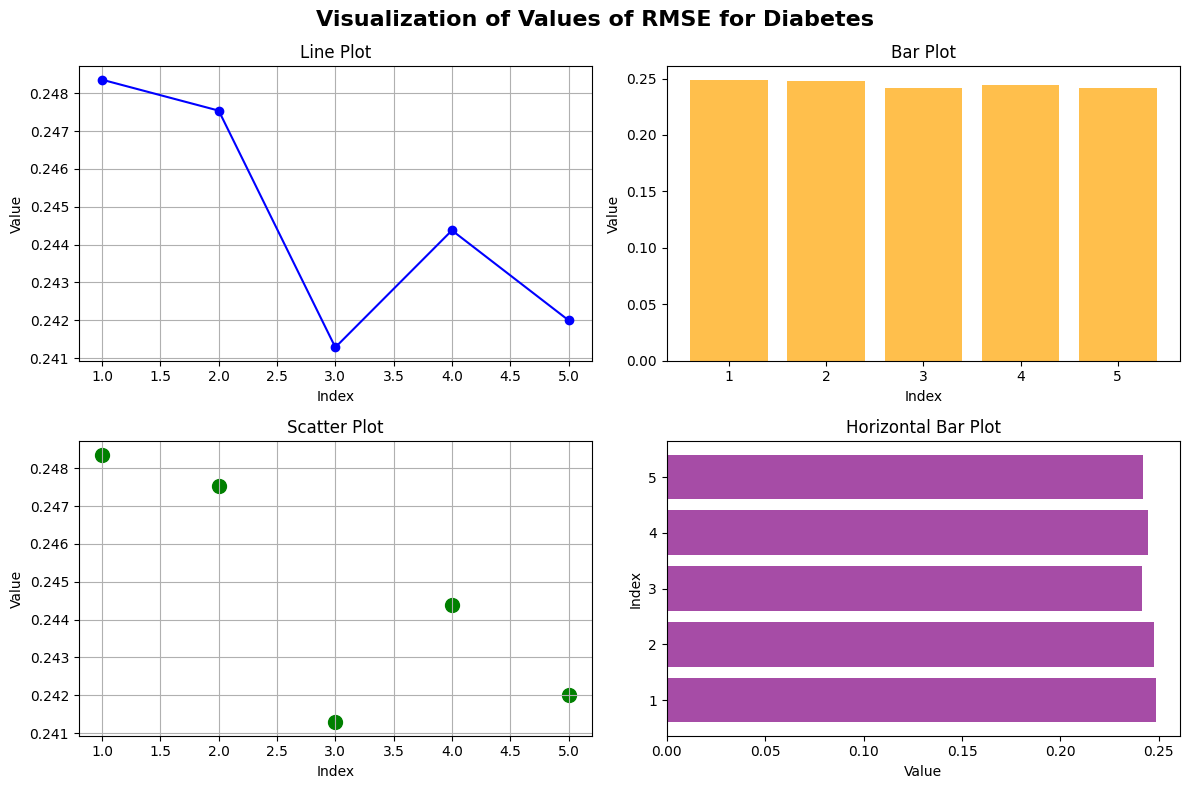

In [186]:
import matplotlib.pyplot as plt
import numpy as np

# Data
values = [0.24836013, 0.24754275, 0.24128455, 0.24437699, 0.242]
indices = np.arange(1, len(values) + 1)

# Plot styles
plt.figure(figsize=(12, 8))

# Line plot
plt.subplot(2, 2, 1)
plt.plot(indices, values, marker='o', linestyle='-', color='b')
plt.title("Line Plot")
plt.xlabel("Index")
plt.ylabel("Value")
plt.grid(True)

# Bar plot
plt.subplot(2, 2, 2)
plt.bar(indices, values, color='orange', alpha=0.7)
plt.title("Bar Plot")
plt.xlabel("Index")
plt.ylabel("Value")

# Scatter plot
plt.subplot(2, 2, 3)
plt.scatter(indices, values, color='green', s=100)
plt.title("Scatter Plot")
plt.xlabel("Index")
plt.ylabel("Value")
plt.grid(True)

# Horizontal bar plot
plt.subplot(2, 2, 4)
plt.barh(indices, values, color='purple', alpha=0.7)
plt.title("Horizontal Bar Plot")
plt.xlabel("Value")
plt.ylabel("Index")


plt.suptitle("Visualization of Values of RMSE for Diabetes", fontsize=16, fontweight='bold')



# Show plots
plt.tight_layout()
plt.show()
